# Importar librerias

In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

# Se transforman los datos, se crean variables exogenas y se coloca la columna datetime como indice

In [235]:
df = pd.read_csv("df_time_serie_2022.csv")
df.FECHA = pd.to_datetime(df.FECHA)
df.set_index("FECHA", inplace=True)


In [236]:
import holidays

# Se eliminan las columnas de más, de igual manera se eliminan los productos con menos de 50 ventas en 2023

In [237]:
df["Dia de la semana"] = df.index.dayofweek
#Add mañana if hora < 8 
df["Mañana"] = 0
df.loc[df.index.hour < 8, "Mañana"] = 1
#add tarde if hora > 8 and hora < 16
df["Tarde"] = 0
df.loc[(df.index.hour > 8) & (df.index.hour < 16), "Tarde"] = 1
#add noche if hora > 16
df["Noche"] = 0
df.loc[df.index.hour > 16, "Noche"] = 1

#add holidays from mexico
mex_holidays = holidays.MX(years=[2022, 2023, 2024])
#add holidays from mexico, if is holiday = 1

df["Feriado"] = 0
for date in mex_holidays.keys():
    df.loc[df.index.date == date, "Feriado"] = 1
    
#vacaciones de mexico por mes y dia
df["Dia laboral"] = 1
df.loc[(df.index.month == 1) & (df.index.day < 6), "Dia laboral"] = 0
df.loc[(df.index.month == 4) & (df.index.day > 11) & (df.index.day < 27), "Dia laboral"] = 0
df.loc[(df.index.month == 12) & (df.index.day > 19), "Dia laboral"] = 0
df.loc[(df.index.month == 7) & (df.index.day > 16), "Dia laboral"] = 0
df.loc[(df.index.month == 8) & (df.index.day < 26), "Dia laboral"] = 0




In [238]:
exog.index.month

Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       ...
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
      dtype='int32', name='FECHA', length=22632)

In [239]:
exog = df[["Dia de la semana","Mes", "Dia", "Hora","Mañana", "Tarde", "Noche","Feriado", "Dia laboral"]]
df.drop(columns=["Dia de la semana","Mes", "Dia", "Hora", "Mañana", "Tarde", "Noche", "Feriado","Dia laboral"], inplace=True)

In [240]:
exog


,Dia de la semana,Mes,Dia,Hora,Mañana,Tarde,Noche,Feriado,Dia laboral
FECHA,,,,,,,,,
2022-01-01 00:00:00,5,1.0,1.0,0.0,1,0,0,1,0
2022-01-01 01:00:00,5,1.0,1.0,1.0,1,0,0,1,0
2022-01-01 02:00:00,5,1.0,1.0,2.0,1,0,0,1,0
2022-01-01 03:00:00,5,1.0,1.0,3.0,1,0,0,1,0
2022-01-01 04:00:00,5,1.0,1.0,4.0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
2024-07-31 21:00:00,2,7.0,213.0,21.0,0,0,1,0,0
2024-07-31 22:00:00,2,7.0,213.0,22.0,0,0,1,0,0
2024-07-31 23:00:00,2,7.0,213.0,23.0,0,0,1,0,0


In [241]:
#Agregar dia del mes
exog["Dia del mes"] = exog.index.day
#Convertir a dummies dia de la semana y mes
exog = pd.get_dummies(exog, columns=["Dia de la semana","Mes"])

C:\Users\jesus\AppData\Local\Temp\ipykernel_31712\766249261.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["Dia del mes"] = exog.index.day


In [242]:
#Convert the days and hour to cos
exog["hour_cos"] = np.cos(2*np.pi*exog["Hora"]/24)
exog["hour_sin"] = np.sin(2*np.pi*exog["Hora"]/24)
exog["day_cos"] = np.cos(2*np.pi*exog["Dia del mes"]/31)
exog["day_sin"] = np.sin(2*np.pi*exog["Dia del mes"]/31)
exog["Dia del año cos"] = np.cos(2*np.pi*exog["Dia"]/365)
exog["Dia del año sin"] = np.sin(2*np.pi*exog["Dia"]/365)
#drop
exog.drop(columns=["Hora","Dia del mes","Dia"], inplace=True)
exog

,Mañana,Tarde,Noche,Feriado,Dia laboral,Dia de la semana_0,Dia de la semana_1,Dia de la semana_2,Dia de la semana_3,Dia de la semana_4,...,Mes_9.0,Mes_10.0,Mes_11.0,Mes_12.0,hour_cos,hour_sin,day_cos,day_sin,Dia del año cos,Dia del año sin
FECHA,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,1,0,0,1,0,False,False,False,False,False,...,False,False,False,False,1.000000,0.000000,0.979530,2.012985e-01,0.999852,0.017213
2022-01-01 01:00:00,1,0,0,1,0,False,False,False,False,False,...,False,False,False,False,0.965926,0.258819,0.979530,2.012985e-01,0.999852,0.017213
2022-01-01 02:00:00,1,0,0,1,0,False,False,False,False,False,...,False,False,False,False,0.866025,0.500000,0.979530,2.012985e-01,0.999852,0.017213
2022-01-01 03:00:00,1,0,0,1,0,False,False,False,False,False,...,False,False,False,False,0.707107,0.707107,0.979530,2.012985e-01,0.999852,0.017213
2022-01-01 04:00:00,1,0,0,1,0,False,False,False,False,False,...,False,False,False,False,0.500000,0.866025,0.979530,2.012985e-01,0.999852,0.017213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 21:00:00,0,0,1,0,0,False,False,True,False,False,...,False,False,False,False,0.707107,-0.707107,1.000000,-2.449294e-16,-0.865307,-0.501242
2024-07-31 22:00:00,0,0,1,0,0,False,False,True,False,False,...,False,False,False,False,0.866025,-0.500000,1.000000,-2.449294e-16,-0.865307,-0.501242
2024-07-31 23:00:00,0,0,1,0,0,False,False,True,False,False,...,False,False,False,False,0.965926,-0.258819,1.000000,-2.449294e-16,-0.865307,-0.501242


In [243]:
df = df.asfreq("h")

Crear Exog asfreq h sin valores nulos, cambiar tipo de valor de bool a int

In [244]:
exog = exog.asfreq("h")
#Convert bool to int
exog = exog.astype(int)

In [245]:
#Add mañana, tarde y noche dependiendo de la hora del dia

In [246]:
# Seleccionar las columnas que contengan la palabra "SURESTE" y no "SURESTE 2" o "SURESTE 3"
x = df.filter(regex=("SURESTE(?! 2| 3)")).columns

# Se divide el test en validacion, test y entrenamiento

In [215]:
# Split data into train-validation-test
# ======================================================================================
end_train = '2024-03-29 23:00:00'
end_val = '2024-07-30 23:00:00'

data_train = df.loc[:end_train, :].copy()
data_val   = df.loc[end_train:end_val, :].copy()
data_test  = df.loc[end_val:, :].copy()
exog_train = exog.loc[:end_train, :].copy()
exog_val   = exog.loc[end_train:end_val, :].copy()
exog_test  = exog.loc[end_val:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2022-01-01 00:00:00 --- 2024-03-29 23:00:00  (n=19656)
Validation dates : 2024-03-29 23:00:00 --- 2024-07-30 23:00:00  (n=2953)
Test dates       : 2024-07-30 23:00:00 --- 2024-07-31 23:00:00  (n=25)


In [258]:
# Split data into train-validation-test
# ======================================================================================
end_train = '2024-07-07 23:00:00'
# end_val = '2024-07-30 23:00:00'

data_train = df.loc[:end_train, :].copy()
# data_val   = df.loc[end_train:end_val, :].copy()
data_test  = df.loc[end_train:, :].copy()
exog_train = exog.loc[:end_train, :].copy()
# exog_val   = exog.loc[end_train:end_val, :].copy()
exog_test  = exog.loc[end_train:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
# print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2022-01-01 00:00:00 --- 2024-07-07 23:00:00  (n=22056)
Test dates       : 2024-07-07 23:00:00 --- 2024-07-31 23:00:00  (n=577)


Medidas a cambiar a futuro:
Tiempo a predecir: 6 horas adelante, 12 horas adelante y un día.

ForecasterAutoregMultiVariate, con todo el dataframe, con una estación.

Algunas de los trends que hay

## Se buscan los mejores hiperparametros para el modelo por grid-search y se guardan en un dataframe

Intento con datos de una estación, solo 6 horas

In [22]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

In [40]:
# Bayesian search hyperparameters and lags with Optuna
modelos_pruebas = {}
# ==============================================================================
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [6, 12, 14]),
        'n_estimators'    : trial.suggest_int('n_estimators', 100, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1., 10),
        'max_features'    : trial.suggest_categorical('max_features', ['log2', 'sqrt']),
        'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 70, 160),
        'max_depth': trial.suggest_int('max_depth', -1, 15),  # -1 for no limit
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)

    }

    return search_space

def r_squared(y_true, y_pred):
    return 1 - r2_score(y_true, y_pred)

for level in df.filter(regex=("PM2.5")).columns:
    forecaster = ForecasterAutoregMultiVariate(
                    regressor = LGBMRegressor(random_state=123, verbose=-1),
                    level     = level, #cambiar nivel a predecir 
                    lags      = 24,
                    steps     = 6
                )
    
    results, best_trial = bayesian_search_forecaster_multiseries(
                            forecaster            = forecaster,
                            series                = df,
                            exog                  = exog, 
                            search_space          = search_space,
                            steps                 = 6,
                            metric                = [r_squared, 'mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error' ],
                            # aggregate_metric      = 'weighted_average',
                            refit                 = False, #Se reentrena cada 3 folds
                            initial_train_size    = len(data_train),
                            fixed_train_size      = False,
                            n_trials              = 5,
                            random_state          = 123,
                            return_best           = False,
                            n_jobs                = 'auto',
                            verbose               = False,
                            show_progress         = True,
                            engine                = 'optuna',
                            kwargs_create_study   = {},
                            kwargs_study_optimize = {}
                            # output_file="results_" + level + ".txt"
                        )
    modelos_pruebas[level] = results
    results.head(4)

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3888234703.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

In [56]:
results.head(1)

,levels,lags,params,r_squared,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,n_estimators,min_samples_leaf,max_features,learning_rate,num_leaves,max_depth,reg_alpha,reg_lambda
0,[NORTE 2 PM2.5 (UG/M3)],"[1, 2, 3, 4, 5, 6]","{'n_estimators': 128, 'min_samples_leaf': 8, '...",0.712143,9.515822,159.22404,0.617961,128,8,sqrt,0.011337,113,5,0.000012,0.036429


In [41]:
# modelos_pruebas to csv all in one csv
# ==============================================================================
for level in df.filter(regex=("PM2.5")).columns:
    modelos_pruebas[level].to_csv("modelos_pruebas.csv", mode='a', header=False)

In [72]:
best_models = pd.read_csv("modelos_pruebas.csv")
best_models

,Unnamed: 0,levels,lags,params,r_squared,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,n_estimators,min_samples_leaf,max_features,learning_rate,num_leaves,max_depth,reg_alpha,reg_lambda
0,0,['SURESTE PM2.5 (UG/M3)'],[1 2 3 4 5 6],"{'n_estimators': 128, 'min_samples_leaf': 8, '...",0.389475,4.311267,31.352664,0.337392,128,8,sqrt,0.011337,113,5,0.000012,0.036429
1,1,['SURESTE PM2.5 (UG/M3)'],[1 2 3 4 5 6],"{'n_estimators': 137, 'min_samples_leaf': 2, '...",0.596323,5.558238,48.003861,0.455911,137,2,sqrt,0.003940,127,13,0.033121,0.003157
2,2,['SURESTE PM2.5 (UG/M3)'],[1 2 3 4 5 6],"{'n_estimators': 111, 'min_samples_leaf': 3, '...",0.793413,6.506344,63.869593,0.539663,111,3,log2,0.002000,109,7,0.000068,0.000006
3,3,['SURESTE PM2.5 (UG/M3)'],[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14],"{'n_estimators': 125, 'min_samples_leaf': 7, '...",0.820694,6.624900,66.065678,0.548044,125,7,sqrt,0.001756,148,3,0.000222,7.413752
4,4,['SURESTE PM2.5 (UG/M3)'],[ 1 2 3 4 5 6 7 8 9 10 11 12],"{'n_estimators': 142, 'min_samples_leaf': 7, '...",0.891907,6.917876,71.798337,0.575187,142,7,log2,0.000817,107,10,0.757027,0.000392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,['NORTE 2 PM2.5 (UG/M3)'],[1 2 3 4 5 6],"{'n_estimators': 128, 'min_samples_leaf': 8, '...",0.712143,9.515822,159.224040,0.617961,128,8,sqrt,0.011337,113,5,0.000012,0.036429
61,1,['NORTE 2 PM2.5 (UG/M3)'],[1 2 3 4 5 6],"{'n_estimators': 137, 'min_samples_leaf': 2, '...",0.859122,10.660903,192.086221,0.706470,137,2,sqrt,0.003940,127,13,0.033121,0.003157
62,2,['NORTE 2 PM2.5 (UG/M3)'],[1 2 3 4 5 6],"{'n_estimators': 111, 'min_samples_leaf': 3, '...",0.993627,11.567317,222.159557,0.769067,111,3,log2,0.002000,109,7,0.000068,0.000006
63,3,['NORTE 2 PM2.5 (UG/M3)'],[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14],"{'n_estimators': 125, 'min_samples_leaf': 7, '...",1.006061,11.655030,224.939534,0.778043,125,7,sqrt,0.001756,148,3,0.000222,7.413752


## CODIGO MUESTRA DE MODELOS DISTINTOS (no correr)

In [ ]:
# Hyperparameter search and backtesting of each item's model
# ======================================================================================
items = []
mae_values  = []
dictes = {}

lags_grid = [7, 14, 21]
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

for i, item in enumerate(data.columns):

    forecaster = ForecasterAutoreg(
                     regressor     = HistGradientBoostingRegressor(random_state=123),
                     lags          = 14,
                     transformer_y = StandardScaler()
                 )

    results_grid = grid_search_forecaster(
                       forecaster         = forecaster,
                       y                  = data.loc[:end_val, item],
                       lags_grid          = lags_grid,
                       param_grid         = param_grid,
                       steps              = 7,
                       exog=exog.loc[:end_val, :],
                       metric             = "mean_absolute_error",
                       initial_train_size = len(data_train),
                       refit              = False,
                       fixed_train_size   = False,
                       return_best        = True,
                       verbose            = False,
                       show_progress      = False 
                  )

    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data[item],
                        exog=exog,
                        initial_train_size = len(data_train) + len(data_val),
                        steps              = 7,
                        metric             = "mean_absolute_error",
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False,
                        show_progress      = False
                    )

    items.append(item)
    mae_values.append(metric)
    dictes[item] = results_grid
    

uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 )

# Forecaster multi-variate to model each region together

In [56]:
sureste = df.filter(regex=("SURESTE")).columns

In [ ]:
sureste

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 level     = 'SURESTE PM2.5 (UG/M3)',
                 lags      = 24,
                 steps     = 6
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [7, 14]),
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1., 10),
        'max_features'    : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }

    return search_space

results, best_trial = bayesian_search_forecaster_multiseries(
                          forecaster            = forecaster,
                          series                = df[sureste],
                          exog                  = exog, 
                          search_space          = search_space,
                          steps                 = 6,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error' ],
                          aggregate_metric      = 'weighted_average',
                          refit                 = 3, #Se reentrena cada 3 folds
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          n_trials              = 5,
                          random_state          = 123,
                          return_best           = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {}
                      )
results.head(4)

Obtener una tabla con R^2,  MSE, RSME

# Se hará un modelo por region

Se puede guardar cada modelo en un csv, que puede ser releido para usarse en el futuro, pero es recomendable reentrenar cada mes

Se crea un dataframe con cada uno de los parametros necesarios

Se entrena cada modelo y se predice para una semana y para un mes, se guarda en un dataframe cada predicción

In [68]:
#Get each first part of the column name
regions = df.columns.str.split(" ").str[0].unique()

In [ ]:
for region in regions:
    # Create and fit forecaster MultiVariate
    # ==============================================================================
    forecaster = ForecasterAutoregMultiVariate(
                    regressor          = LGBMRegressor(random_state=123, verbose=-1),
                    level              = 'SURESTE PM2.5 (UG/M3)', #Hay que hacer que cambie de SURESTE a SURESTE 2, 3 y cada region tiene sus propios numeros
                    lags               = 21,
                    steps              = 6,
                    transformer_series = StandardScaler(),
                    transformer_exog   = None,
                    weight_func        = None,
                    n_jobs             = 'auto'
                    min_samples_leaf   = 9,
                    n_estimators       = 10,
                    max_features       = 'log2'
                    
                )

    forecaster.fit(series=data_train.filter(regex=(region)), exog=exog_train)
    predictions = forecaster.predict(steps=6, last_window=data_val.filter(regex=(region)), exog=exog_val)
    

In [22]:
    # Create and fit forecaster MultiVariate
    # ==============================================================================
regresor = LGBMRegressor(random_state=123, verbose=-1, n_estimators=145, min_samples_leaf=1, max_features='False', learning_rate=0.19844611443148058, num_leaves=29, max_depth=12, reg_alpha=0.6120379139339559, reg_lambda=0.7732501918150064)
# regresor = LGBMRegressor(random_state=123, verbose=-1, n_estimators=128, min_samples_leaf=8, max_features='sqrt', learning_rate=0.01133676686701445, num_leaves=113, max_depth=5, reg_alpha=1.2263152961306247e-05, reg_lambda=0.03642900979056708)
    
forecaster = ForecasterAutoregMultiVariate(
                regressor          = regresor,
                level              = 'SURESTE PM2.5 (UG/M3)', #Hay que hacer que cambie de SURESTE a SURESTE 2, 3 y cada region tiene sus propios numeros
                lags               = 6,
                steps              = 12,
                transformer_series = StandardScaler(),
                transformer_exog   = None,
                weight_func        = None,
                n_jobs             = 'auto'
                    
            )

forecaster.fit(series=data_train.filter(regex=("SURESTE")), exog=exog_train)


In [23]:
predictions = forecaster.predict(steps=12,exog=exog_val.loc["2024-03-01 00:00:00":])


Puede predecir 6 horas

2024-07-31 05:00:00

In [24]:
predictions

,SURESTE PM2.5 (UG/M3)
2024-03-01 00:00:00,16.648894
2024-03-01 01:00:00,15.570700
2024-03-01 02:00:00,17.912461
2024-03-01 03:00:00,16.820976
2024-03-01 04:00:00,17.821699
2024-03-01 05:00:00,21.412694
2024-03-01 06:00:00,18.373167
2024-03-01 07:00:00,14.911406
2024-03-01 08:00:00,17.787838
2024-03-01 09:00:00,19.166446


In [25]:
# Get the models stats
data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12)

,SURESTE PM2.5 (UG/M3)
FECHA,
2024-03-01 00:00:00,18.728424
2024-03-01 01:00:00,15.000000
2024-03-01 02:00:00,14.000000
2024-03-01 03:00:00,15.000000
2024-03-01 04:00:00,15.000000
2024-03-01 05:00:00,16.000000
2024-03-01 06:00:00,19.000000
2024-03-01 07:00:00,22.000000
2024-03-01 08:00:00,24.000000


In [26]:
# Get the R^2, RMSE, MAE and MAPE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
r2 = r2_score(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions)
rmse = mean_squared_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions, squared=False)
mae = mean_absolute_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions)
mape = mean_absolute_percentage_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions)

print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")


R^2: 0.0760945148246428
RMSE: 8.690049363394191
MAE: 6.426430196018482
MAPE: 0.24541306825124012


c:\Users\jesus\anaconda3\envs\datathon2024\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


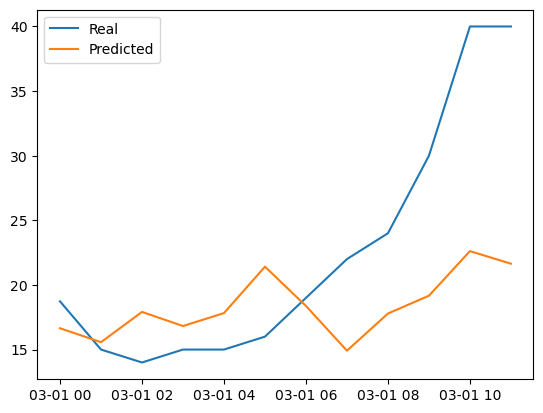

In [27]:
# Plot the predicted, vs real
plt.plot(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), label="Real")
plt.plot(predictions, label="Predicted")
plt.legend()

# Modelo con datos de una sola estacion

In [33]:
    # Create and fit forecaster MultiVariate
    # ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                regressor          = LGBMRegressor(random_state=123, verbose=-1),
                level              = 'SURESTE PM2.5 (UG/M3)', #Hay que hacer que cambie de SURESTE a SURESTE 2, 3 y cada region tiene sus propios numeros
                lags               = 14,
                steps              = 24,
                transformer_series = StandardScaler(),
                transformer_exog   = None,
                weight_func        = None,
                n_jobs             = 'auto',
                    
            )

forecaster.fit(data_train.filter(regex=("SURESTE(?! 2| 3)")), exog=exog_train)

KeyboardInterrupt: 

In [56]:
predictions = forecaster.predict(steps=24, exog=exog_val.loc["2024-03-01 00:00:00":])
predictions


,SURESTE PM2.5 (UG/M3)
2024-03-01 00:00:00,16.736356
2024-03-01 01:00:00,16.338487
2024-03-01 02:00:00,16.329758
2024-03-01 03:00:00,16.928768
2024-03-01 04:00:00,16.184626
2024-03-01 05:00:00,18.644283
2024-03-01 06:00:00,16.842215
2024-03-01 07:00:00,20.887210
2024-03-01 08:00:00,20.088968
2024-03-01 09:00:00,21.145663


In [57]:
# Get the R^2, RMSE, MAE and MAPE
r2 = r2_score(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions)
rmse = mean_squared_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions, squared=False)
mae = mean_absolute_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions)
mape = mean_absolute_percentage_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions)

print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

R^2: 0.32185812339974573
RMSE: 7.4579911515389705
MAE: 5.004610060834536
MAPE: 0.1801342778142503


c:\Users\progra.DESKTOP-GV4Q93K\miniconda3\envs\personal\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


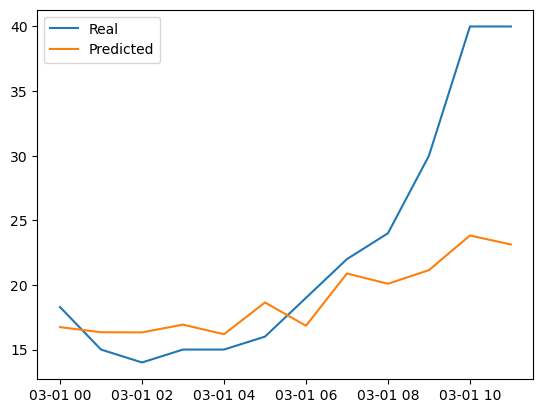

In [58]:
# Plot the predicted, vs real
plt.plot(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), label="Real")
plt.plot(predictions, label="Predicted")
plt.legend()

# Modelo con todos los datos

In [259]:
    # Create and fit forecaster MultiVariate
    # ==============================================================================
regresor = LGBMRegressor(random_state=123, verbose=-1, n_estimators=145, min_samples_leaf=1, max_features='False', learning_rate=0.19844611443148058, num_leaves=29, max_depth=12, reg_alpha=0.6120379139339559, reg_lambda=0.7732501918150064)
forecaster = ForecasterAutoregMultiVariate(
                regressor          = regresor,
                level              = 'SURESTE PM2.5 (UG/M3)', #Hay que hacer que cambie de SURESTE a SURESTE 2, 3 y cada region tiene sus propios numeros
                lags               = 6,
                steps              = 48,
                transformer_series = StandardScaler(),
                transformer_exog   = None,
                weight_func        = None,
                n_jobs             = 'auto',
                    
            )

forecaster.fit(data_train, exog=exog_train)

In [269]:
predictions = forecaster.predict_interval(steps=48, exog=exog_val.loc["2024-07-08 00:00:00":])

In [280]:
predictions

,SURESTE PM2.5 (UG/M3),SURESTE PM2.5 (UG/M3)_lower_bound,SURESTE PM2.5 (UG/M3)_upper_bound
2024-07-08 00:00:00,10.493307,8.034438,13.799131
2024-07-08 01:00:00,11.601036,8.708091,15.499979
2024-07-08 02:00:00,14.615628,11.233349,18.887106
2024-07-08 03:00:00,13.485146,9.300575,17.949053
2024-07-08 04:00:00,14.140603,10.539040,18.849688
2024-07-08 05:00:00,15.372775,11.438868,20.107173
2024-07-08 06:00:00,17.434277,13.220879,22.715364
2024-07-08 07:00:00,13.045810,8.616994,17.655210
2024-07-08 08:00:00,18.777779,13.939299,23.400271
2024-07-08 09:00:00,17.989063,12.644018,23.157632


In [273]:
# Get the R^2, RMSE, MAE and MAPE
r2 = r2_score(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-07-08 00:00:00":].head(48), predictions['SURESTE PM2.5 (UG/M3)'])
rmse = mean_squared_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-07-08 00:00:00":].head(48), predictions['SURESTE PM2.5 (UG/M3)'], squared=False)
mae = mean_absolute_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-07-08 00:00:00":].head(48), predictions['SURESTE PM2.5 (UG/M3)'])
mape = mean_absolute_percentage_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-07-08 00:00:00":].head(48), predictions['SURESTE PM2.5 (UG/M3)'])

print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

R^2: -0.4506111330132814
RMSE: 5.200432661170552
MAE: 4.557299149715978
MAPE: 0.3777988319362515


c:\Users\jesus\anaconda3\envs\datathon2024\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [220]:
#-filtrar solo los datos de 
data_train.filter(regex=("SURESTE PM2.5")).loc["2024-01-01":"2024-02-01"]

,SURESTE PM2.5 (UG/M3)
FECHA,
2024-01-01 00:00:00,60.000000
2024-01-01 01:00:00,60.520000
2024-01-01 02:00:00,36.883307
2024-01-01 03:00:00,64.690000
2024-01-01 04:00:00,44.130000
...,...
2024-02-01 19:00:00,13.458628
2024-02-01 20:00:00,16.660000
2024-02-01 21:00:00,19.590000


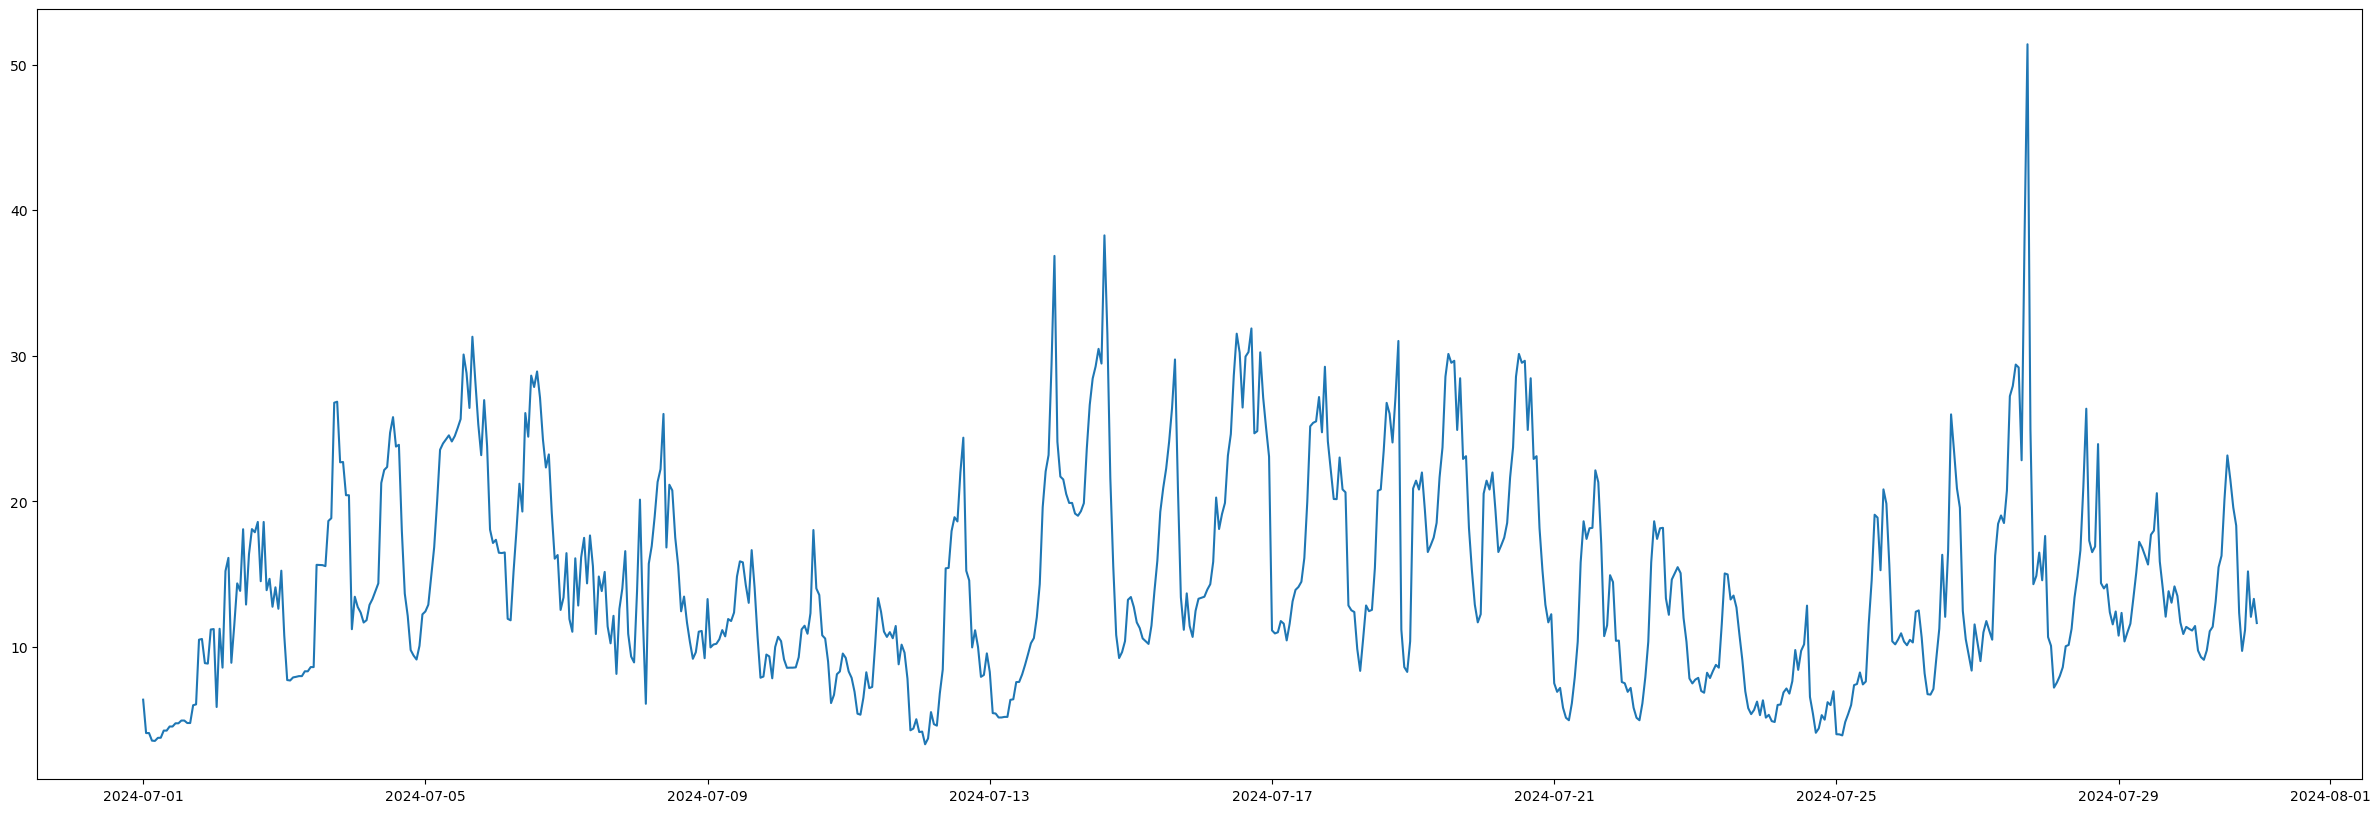

In [255]:
plt.figure(figsize=(30,10))
plt.plot(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-07-01":], label="Real")


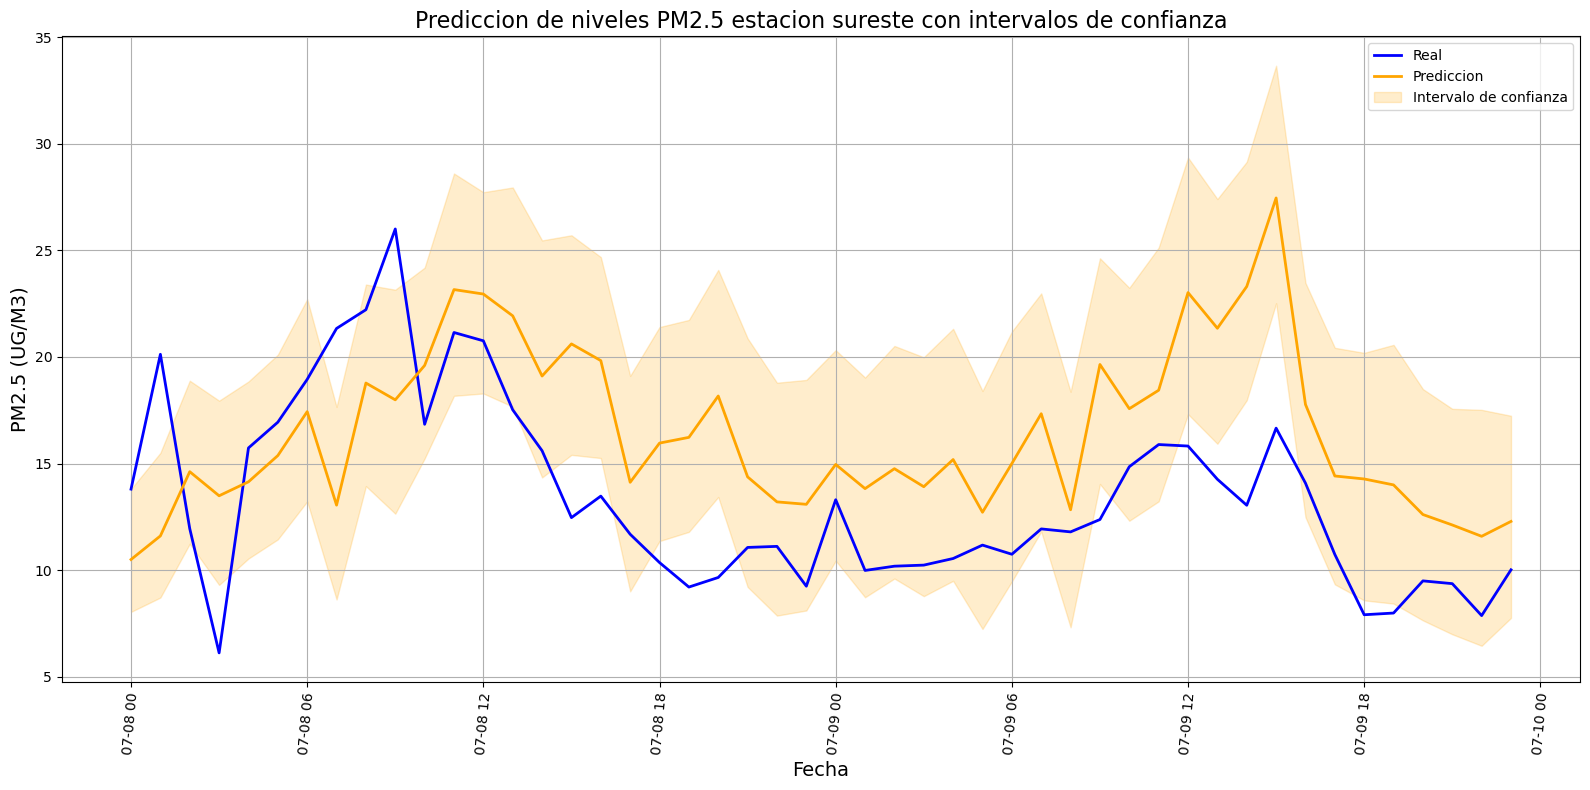

In [279]:
# Create the figure and plot the real and predicted values
plt.figure(figsize=(16,8))

# Plot real data
plt.plot(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-07-08":].head(48), label="Real", color="blue", linewidth=2)

# Plot predicted values
plt.plot(predictions['SURESTE PM2.5 (UG/M3)'].head(48), label="Prediccion", color="orange", linewidth=2)

# Add the confidence interval
plt.fill_between(
    predictions.index[:48], 
    predictions['SURESTE PM2.5 (UG/M3)_lower_bound'].head(48),  # Lower bound for the confidence interval
    predictions['SURESTE PM2.5 (UG/M3)_upper_bound'].head(48),  # Upper bound for the confidence interval
    color='orange', alpha=0.2, label="Intervalo de confianza"
)

# Rotate x-axis ticks for better readability
plt.xticks(rotation=85)

# Add title and labels for better context
plt.title("Prediccion de niveles PM2.5 estacion sureste con intervalos de confianza", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("PM2.5 (UG/M3)", fontsize=14)

# Add grid to make it visually clear
plt.grid(True)

# Add legend to clarify the plot
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig("SURESTE_PM2.5.png", dpi=400)
plt.show()


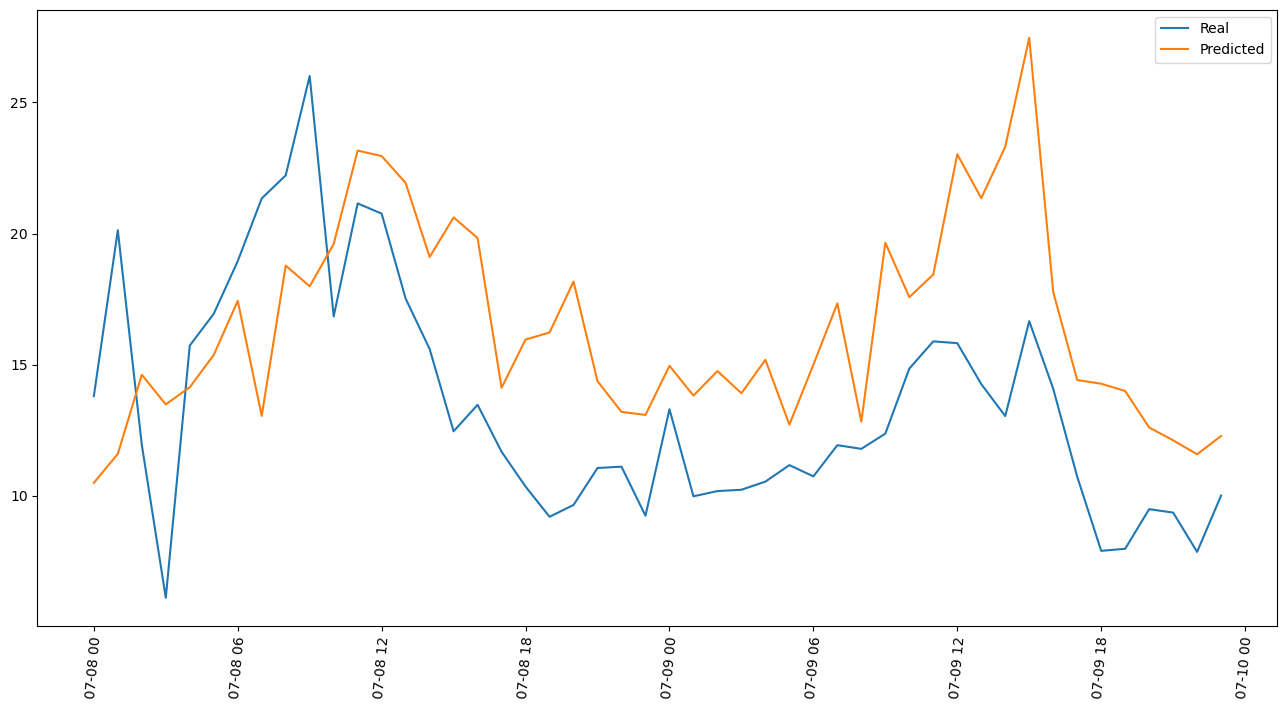

In [274]:
# Plot the predicted, vs real
plt.figure(figsize=(16,8))
plt.plot(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-07-08":].head(48), label="Real")
plt.plot(predictions['SURESTE PM2.5 (UG/M3)'].head(48), label="Predicted")
plt.xticks(rotation=85)
plt.legend()

In [230]:
from skforecast.plot import plot_residuals

c:\Users\jesus\anaconda3\envs\datathon2024\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


ValueError: `dataset` input should have multiple elements.

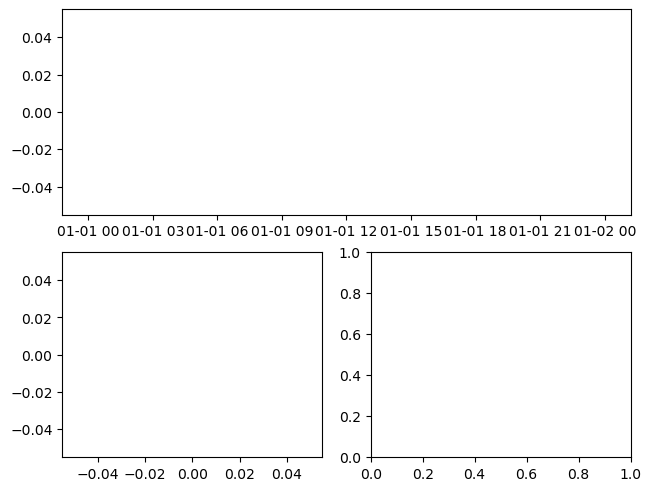

In [282]:
#Plot residuals
residuals = data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01":].head(48) - predictions
plot_residuals(residuals)


In [232]:
#Feature importance
# ==============================================================================
# Get feature importances
importances = forecaster.get_feature_importances(5)

importances

,feature,importance
36,SURESTE PM2.5 (UG/M3)_lag_1,51
396,SUROESTE PM2.5 (UG/M3)_lag_1,33
1242,NORESTE 3 WSR (KMPH)_lag_1,24
438,SUROESTE WSR (KMPH)_lag_1,20
756,SURESTE 2 PM2.5 (UG/M3)_lag_1,15
...,...,...
135,NORESTE PRS (MMHG)_lag_4,0
137,NORESTE PRS (MMHG)_lag_6,0
138,NORESTE RAINF (MM/HR)_lag_1,0
139,NORESTE RAINF (MM/HR)_lag_2,0


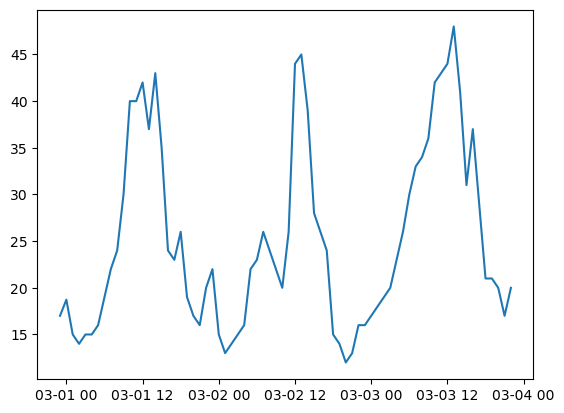

In [51]:
plt.plot(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-02-28":].head(72), label="Real")

In [ ]:
plt.plot(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-02-01":].head(36), label="Real")
plt.plot(predictions, label="Predicted")
plt.legend()

In [32]:
for i in models.index:
    forecaster = ForecasterAutoreg(
                     regressor     = HistGradientBoostingRegressor(random_state=123, max_depth=models.loc[i,"max_depth"], max_iter=models.loc[i,"max_iter"], learning_rate=models.loc[i,"learning_rate"]),
                     lags          = [models.loc[i,"lags"].max()],
                     transformer_y = StandardScaler()
                 )
    forecaster.fit(y=data.loc[:"2023-11-30",i], exog=exog.loc[:"2023-11-30", :])
    month_pred[i] = forecaster.predict(steps=31, exog=exog.loc["2023-12-01":])
    week_pred[i] = forecaster.predict(steps=8, exog=exog.loc["2023-12-01":])

Se ayuda un poco al modelo dado que los valores negativos no existen en los productos

Se consiguen las estadisticas que tiene el modelo para predecir durante un mes y durante una semana

In [ ]:
stats_mes = pd.DataFrame()
for i in month_pred.columns:
    y_pred = month_pred[i]
    y_test = data.loc["2023-12-01":"2023-12-31",i]
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    mape2 = abs((y_pred - y_test)/y_test).replace([np.inf, -np.inf], np.log(0.9999999999999999999999999)).dropna().sum()/30
    mape3 = (np.abs((y_test - y_pred)/np.where(y_test==0, 1, y_test))).mean()
    smape = 1/len(y_test) * np.sum(2*np.abs(y_pred - y_test)/(np.abs(y_pred) + np.abs(y_test))*100)
    valor_real = y_test.sum()
    valor_pred = y_pred.sum()
    error = (valor_real - valor_pred)/valor_real
    error_semanal = error/4 * 100
    stats_mes = pd.concat([stats_mes, pd.DataFrame({"Producto":i, "MAE":mae, "MSE":mse, "R2":r2, "SMAPE": smape,"MAPE lib":mape,"MAPE2":mape2,"MAPE3":mape3, "valor real": 
        valor_real, "valor predecido": valor_pred, "error":error*100, "error por semana": error_semanal}, index=[0])], axis=0)
stats_mes

In [ ]:
stats_semana = pd.DataFrame()
for i in month_pred.columns:
    y_pred = week_pred[i]
    y_test = data.loc["2023-12-01":"2023-12-8",i]
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    mape2 = abs((y_pred - y_test)/y_test).replace([np.inf, -np.inf], np.log(0.9999999999999999999999999)).dropna().sum()/30
    mape3 = (np.abs((y_test - y_pred)/np.where(y_test==0, 1, y_test))).mean()
    smape = 1/len(y_test) * np.sum(2*np.abs(y_pred - y_test)/(np.abs(y_pred) + np.abs(y_test))*100)
    valor_real = y_test.sum()
    valor_pred = y_pred.sum()
    error = (valor_real - valor_pred)/valor_real *100
    stats_semana = pd.concat([stats_semana, pd.DataFrame({"Producto":i, "MAE":mae, "MSE":mse, "R2":r2, "SMAPE": smape,"MAPE lib":mape,"MAPE2":mape2,"MAPE3":mape3, "valor real": 
        valor_real, "valor predecido": valor_pred, "error":error}, index=[0])], axis=0)
stats_semana

In [ ]:
#Save figure#
for i in month_pred.columns:
    fig, ax=plt.subplots(figsize=(7, 3))
    month_pred[i].plot(ax=ax,color='red', linestyle='--', label='Predicciones')
    data.loc["2023-12-01":"2023-12-31",i].plot(ax=ax,color='blue', linestyle='-', label='Valores reales')
    ax.set_title(i)
    ax.legend()
    ax.set_ylabel('Ventas')
    ax.set_xlabel('Fecha')
    #plt.savefig(f"pred_mensual_{i}.png")
    

## Agregar modelo del otro producto y comparar

In [ ]:
for i in week_pred.columns:
    fig, ax=plt.subplots(figsize=(7, 3))
    week_pred[i].plot(ax=ax,color='#ECA24E', linestyle='--', label='Predicciones', linewidth=2.5)
    data.loc["2023-12-01":"2023-12-08",i].plot(ax=ax,color='#1f93cf', linestyle='-', label='Valores reales', linewidth=2.5)
    ax.set_title(i, color = 'white')
    ax.set_facecolor('#0e4588')
    ax.grid(color='white')
    #ax.tick_params(axis='x', colors='white')
    #ax.spines['bottom'].set_color('white')
    #ax.spines['top'].set_color('white')
    #ax.xaxis.label.set_color('white')
    #ax.tick_params(axis='x', colors='white', labelsize = 10, which = 'major')
    fig.set_facecolor('#1f93cf')
    ax.set_ylabel('Ventas',color='white') 
    ax.set_xlabel('Fecha',color='white')
    plt.xticks(color='white', weight='bold')
    plt.yticks(color='white', weight='bold')
    #plt.legend(color='white')
    ax.legend()

In [ ]:
resid = data["Producto 0"].loc["2023-10-21":"2023-10-28"] - predicts

In [ ]:
week_pred.to_csv("predicciones_semanales_HGB.csv")
month_pred.to_csv("predicciones_mensuales_HGB.csv")
data.to_csv("datatop20.csv")